# CatBoost model for Ames

# Contents

[CatBoost](#CatBoost)

[Model tuning](#Model-Tuning)

[Feature Importances](#Feature-Importances)

[Summary](#Summary)

[Resources](#Resources)

In [ ]:
#!pip install --upgrade pip
#!pip install catboost

In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor

## Import raw data for reference

In [5]:
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


## Import cleaned data for modeling

**Summary of previous data cleaning:**

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [7]:
ames = pd.read_pickle('ames_clean.pkl')
ames.head(2)

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,126000,30,RL,68.0,7890,Pave,None,Reg,Lvl,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,139500,120,RL,42.0,4235,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,2,2009,WD,Normal


In [9]:
# remove target from dataframe
y = ames['SalePrice']
ames.drop(columns=['SalePrice'], axis=1, inplace=True)
ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


In [11]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [13]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [15]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
# extract ordinal_features_list from ordinal_order below
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [17]:
# # Define categorical features
# categorical_features_list = ames.select_dtypes(include=['object']).columns.to_list()
# print(f'number of categorical features: {len(categorical_features_list)}')
# categorical_features = ames[categorical_features_list]
# categorical_features.head(2)

OverallQual and OverallCond, while reclassified as object types, are still int types. Convert OverallQual, OverallCond, YrSold, and MoSold from int type to str type for ordinal encoding.

In [20]:
str_OverallQual = ames['OverallQual'].astype(str)
str_OverallCond = ames['OverallCond'].astype(str)
print(type(ames['OverallQual'][0]))
print(type(str_OverallQual[0]))

<class 'int'>
<class 'str'>


In [22]:
ames['OverallCond'] = ames['OverallCond'].astype(str)
ames['OverallQual'] = ames['OverallQual'].astype(str)
ames['MoSold'] = ames['MoSold'].astype(str)
ames['YrSold'] = ames['YrSold'].astype(str)

In [25]:
# define ordering for ordinal features
ordinal_order = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # Electrical system
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],  # General shape of property
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],  # Type of utilities available
    'LandSlope': ['Sev', 'Mod', 'Gtl'],  # Slope of property
    # Overalls here in other notebook
    'OverallQual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'OverallCond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    #
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the quality of the material on the exterior
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Evaluates the present condition of the material on the exterior
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Height of the basement
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # General condition of the basement
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],  # Walkout or garden level basement walls
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of basement finished area
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],  # Quality of second basement finished area
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Heating quality and condition
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Kitchen quality
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],  # Home functionality
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Fireplace quality
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],  # Interior finish of the garage
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage quality
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],  # Garage condition
    'PavedDrive': ['N', 'P', 'Y'],  # Paved driveway
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],  # Pool quality
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],  # Fence quality
    'MoSold': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    'YrSold': ['2006', '2007', '2008', '2009', '2010']
    # 'MoSold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  
    # 'YrSold': [2006, 2007, 2008, 2009, 2010]
}

In [27]:
# get list of ordinal features that syncs with ordinal dictionary 
ordinal_features_list = list(ordinal_order.keys())
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [29]:
# stack features for processing: numerical + nominal + ordinal
X = ames[numerical_features_list].join(ames[nominal_features_list])
X = X.join(ames[ordinal_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


# CatBoost

[Contents](#Contents)

**Method:**

1. Prepare data for modeling
- numerical features: no scaling
- categorical features: encoding not necessary
  - specify categorical feature indices with cat_features parameter
- missing values: can handle missing values. imputation not necessary
- can model on raw data

2. Get a base model: evaluate model on full dataset and default parameters using cross validation
   
3. Tune hyperparameters with GridSearchCV 
- fit grid object to full dataset and retrieve cv score for full dataset (X and y). This is the score that will be used to evaluate the model and compare to other models. 
- fit grid object to train and test data to examine train-test gap for overfitting.

4. Choose best optimized model (based on highest cv score)

# 1. Prepare data

In [34]:
ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


In [36]:
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   object 
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2580 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          2580 non-null   object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   object 
 18  OverallC

In [38]:
# make a copy 
cb_ames = ames.copy()

In [40]:
X = ames.copy()
X.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,68.0,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal


In [42]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2580, dtype: int64

In [44]:
# Identify categorical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

# 2. Base Model
Evaluate model on full dataset and default params using cross-validation

In [53]:
# Initialize CatBoost regressor with native handling for categorical data
cb_model = CatBoostRegressor(
    cat_features = cat_features,
    random_state=42,
    verbose=0
)

In [49]:
# create storage for tuning results
tuning_results = {}

In [78]:
# train model on full data set
cb_model.fit(X, y)

# evaluate full model
scores = cross_val_score(cb_model, X, y, cv=5, scoring='r2')
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'CatBoost base-model mean cv score with manually imputed data:', round(mean_score_base_model, 4))

# split data to evaluate overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

# retrain and evaluate model on train data
cb_model.fit(X_train, y_train)
train_score = cb_model.score(X_train, y_train)
test_score = cb_model.score(X_test, y_test)
diff = train_score - test_score
print(f'CatBoost base-model train score:', round(train_score, 4))
print(f'CatBoost base-model test score:', round(test_score, 4))
print(f'train-test gap:', round(diff, 4))

# store results
tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

cv scores: [0.88087506 0.92130329 0.94334999 0.93769547 0.94659947]
CatBoost base-model mean cv score with manually imputed data: 0.926
CatBoost base-model train score: 0.983
CatBoost base-model test score: 0.9363
train-test gap: 0.0467


### These scores were for my cleaned data set (with my imputations). How does CatBoost do, by comparison, with native handling of features? 

### Compare with raw data (no imputations). 
Compare how CatBoost models the raw data and the manually imputed data:

In [57]:
cb_raw_ames = ames_raw.copy()
cb_raw_ames.drop(columns=['PID', 'SalePrice'], inplace=True)
cb_raw_ames

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,1001,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,1039,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,1665,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,...,40,0,NaN,NaN,NaN,0,5,2009,WD,Normal
2576,1733,20,RL,NaN,13680,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
2577,2002,90,RH,82.0,6270,Pave,NaN,Reg,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
2578,1842,60,RL,NaN,8826,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal


In [59]:
cb_raw_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   int64  
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2118 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          168 non-null    object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   int64  
 18  OverallC

### Change OverallCond, OverallQual, MSSubClass, MoSold, YrSold to 'category' dtypes
to be consistent with data cleaning across other models. 

These features were determined to be categorical through my EDA, and should also be marked as 'category' types, not 'integer' types. 

In [62]:
# make a list of features to change 
int_to_cat_cols = ['OverallCond', 'OverallQual', 'MSSubClass', 'MoSold', 'YrSold']
cb_raw_ames[int_to_cat_cols] = cb_raw_ames[int_to_cat_cols].astype('object')

In [64]:
cb_raw_ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   object 
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2118 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          168 non-null    object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   object 
 18  OverallC

In [66]:
cb_raw_ames.head(2)

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [68]:
X_raw = cb_raw_ames.copy()

In [70]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2580, dtype: int64

In [72]:
# define categorical features
cat_features = X_raw.select_dtypes(include=['object']).columns.tolist()
cat_features

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [74]:
# because there are NaN values in the raw data, convert to string type (for CatBoost)
for col in cat_features:
    X_raw[col] = X_raw[col].astype(str)

In [76]:
# Initialize CatBoost regressor with native handling for categorical data
cb_model = CatBoostRegressor(
    cat_features = cat_features,
    random_seed=42,
    verbose=0
)

In [84]:
# train model on full data set
cb_model.fit(X_raw, y)

# evaluate full model
scores = cross_val_score(cb_model, X_raw, y, cv=5, scoring='r2')
mean_score_raw = scores.mean()
print(f'cv scores:', scores)
print(f'CatBoost base-model, native handling mean cv score:', round(mean_score_raw, 4))

# split data to evaluate overfitting
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state = 0)

# retrain and evaluate model on train data
cb_model.fit(X_train, y_train)
train_score_raw = cb_model.score(X_train, y_train)
test_score_raw = cb_model.score(X_test, y_test)
diff_raw = train_score_raw - test_score_raw
print(f'CatBoost base-model, native handling train score:', round(train_score_raw, 4))
print(f'CatBoost base-model, native handling test score:', round(test_score_raw, 4))
print(f'train-test gap:', round(diff_raw, 4))

# store results
tuning_results['Model _0_raw'] = {
    'mean-cv on X and y': round(mean_score_raw, 4),
    'train score': round(train_score_raw, 4),
    'test score': round(test_score_raw, 4),
    'train-test gap': round(diff_raw, 4)                   
}


cv scores: [0.88054643 0.92574442 0.94321921 0.93845945 0.9433845 ]
CatBoost base-model, native handling mean cv score: 0.9263
CatBoost base-model, native handling train score: 0.9834
CatBoost base-model, native handling test score: 0.9404
train-test gap: 0.043


In [86]:
tuning_results

{'Model _0': {'mean-cv on X and y': 0.926,
  'train score': 0.983,
  'test score': 0.9363,
  'train-test gap': 0.0467},
 'Model _0_raw': {'mean-cv on X and y': 0.9263,
  'train score': 0.9834,
  'test score': 0.9404,
  'train-test gap': 0.043}}

# 3. Model Tuning
[Contents](#Contents)

Tune models with train-test split data, using train-test gap to evaluate overfitting. 

In [97]:
# re-split data on X, y (used X_raw above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [99]:
# Define parameter grid
param_grid_1 = {
    'iterations': [100, 200],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize model
cb_model_1 = CatBoostRegressor(
    cat_features=cat_features,
    random_seed=42,
    verbose=0
)

# Grid search
grid_1 = GridSearchCV(
    cb_model_1, 
    param_grid_1, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
grid_1.fit(X, y)
cb_best_model_1 = grid_1.best_estimator_

# evaluate on full dataset, X and y
model_params = grid_1.best_params_
full_cv = round(grid_1.best_score_, 4)
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
grid_1.fit(X_train, y_train)
best_train_model = grid_1.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _1'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MODEL _1:
Evaluate model on full dataset:
model parameters: {'depth': 6, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
mean cv score on full dataset: 0.9211
-----------
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Check for overfitting on train-test data:
train score: 0.9736
test score: 0.9318
train-test gap: 0.0418


In [101]:
# Define parameter grid
param_grid_2 = {
    'iterations': [200, 300],
    'learning_rate': [0.1, 0.5],
    'depth': [8, 10]
}

# Initialize model
cb_model_2 = CatBoostRegressor(
    cat_features=cat_features,
    random_seed=42,
    verbose=0
)

# Grid search
grid_2 = GridSearchCV(
    cb_model_2, 
    param_grid_2, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit on all the data and score
grid_2.fit(X, y)
cb_best_model_2 = grid_2.best_estimator_

# evaluate on full dataset, X and y
model_params = grid_2.best_params_
full_cv = round(grid_2.best_score_, 4)
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters:', model_params)
print(f'mean cv score on full dataset:', full_cv)
print('-----------')

# Check for overfitting on train-test data
grid_2.fit(X_train, y_train)
best_train_model = grid_2.best_estimator_
train_score = best_train_model.score(X_train, y_train)
test_score = best_train_model.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

# store results
tuning_results['Model _2'] = {
    'mean-cv on X and y': round(full_cv, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4)                   
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MODEL _2:
Evaluate model on full dataset:
model parameters: {'depth': 8, 'iterations': 300, 'learning_rate': 0.1}
mean cv score on full dataset: 0.92
-----------
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Check for overfitting on train-test data:
train score: 0.9848
test score: 0.9261
train-test gap: 0.0587


In [105]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _0_raw,0.9263,0.9834,0.9404,0.0430
Model _0,0.9260,0.9830,0.9363,0.0467
Model _1,0.9211,0.9736,0.9318,0.0418
Model _2,0.9200,0.9848,0.9261,0.0587


The best model performance is on the default base model with raw data

# 4. Best Model 
Choose best optimized model based on highest cv score fit to full dataset

# Feature Importances

[Contents](#Contents)

Look at most important features for optimized model, built on full dataset

In [113]:
# initialize CatBoost regressor with optimized parameters
final_model = CatBoostRegressor(
    cat_features = cat_features,
    random_state=42,
    verbose=0
)
final_model.fit(X_raw, y)

In [119]:
cross_val_score(final_model, X_raw, y).mean()

0.92627080194993

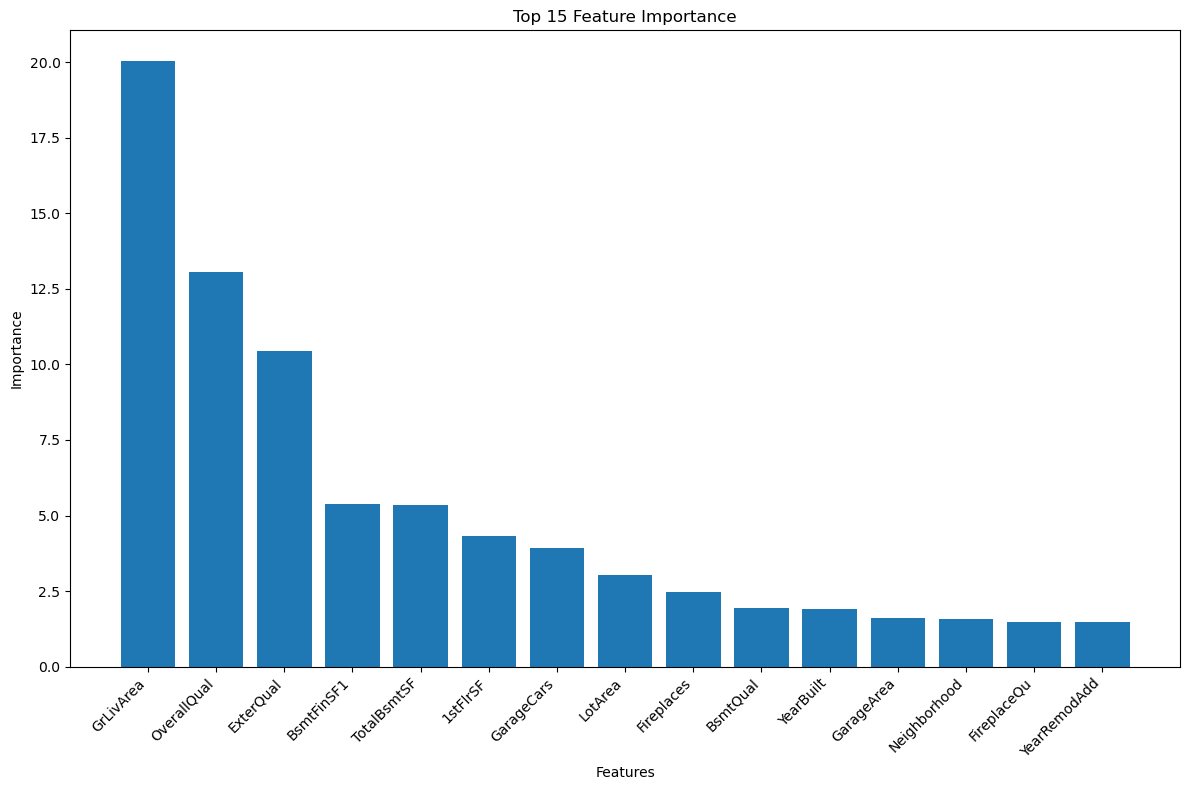

In [121]:
# Get feature importance values
feature_importance = final_model.get_feature_importance()

# Get feature names
feature_names = X.columns if hasattr(X, 'columns') else [f'feature_{i}' for i in range(len(feature_importance))]

# Get top 15 features
top_n = 15
indices = np.argsort(feature_importance)[::-1][:top_n]  # Top 15 indices

plt.figure(figsize=(12, 8))
plt.bar(range(top_n), feature_importance[indices])
plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title('Top 15 Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [125]:
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

In [127]:
feature_importances_df

,feature,Importance
0,GrLivArea,20.049235
17,OverallQual,13.059694
27,ExterQual,10.451518
34,BsmtFinSF1,5.386018
38,TotalBsmtSF,5.361549
...,...,...
74,MiscVal,0.007144
70,PoolArea,0.005185
47,BsmtHalfBath,0.002498
9,Utilities,0.000508


# Shap Values 

[Contents](#Contents)

Use model trained on split raw data for SHAP analysis

In [130]:
import shap
# train model on training data for SHAP analysis
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state = 0)

# Initialize optimized CatBoost regressor
final_model = CatBoostRegressor(
    cat_features = cat_features,
    random_state=42,
    verbose=0
)

# train model
final_model.fit(X_train, y_train)

print(f"Model trained on {X_train.shape[0]} houses with {X_train.shape[1]} features")

Model trained on 2064 houses with 79 features


In [132]:
# evaluate on optimized model
explainer = shap.TreeExplainer(final_model)

In [134]:
# From Vinod's article
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test)

print(f"SHAP values calculated for {shap_values.shape[0]} predictions")
print(f"Each prediction explained by {shap_values.shape[1]} features")
 
# The base value (expected value) - what the model predicts on "average"
print(f"Model's base prediction (expected value): ${explainer.expected_value:,.2f}")
 
# Quick verification: SHAP values should be additive
sample_idx = 0
model_pred = final_model.predict(X_test.iloc[[sample_idx]])[0]
shap_sum = explainer.expected_value + np.sum(shap_values[sample_idx])
print(f"Verification - Model prediction: ${model_pred:,.2f}")
print(f"Verification - SHAP sum: ${shap_sum:,.2f} (difference: {abs(model_pred - shap_sum):.2f})") 

Calculating SHAP values...
SHAP values calculated for 516 predictions
Each prediction explained by 79 features
Model's base prediction (expected value): $177,401.47
Verification - Model prediction: $147,444.83
Verification - SHAP sum: $147,444.83 (difference: 0.00)


## Local feature insights
Looking at individual houses

Analyzing prediction for house index 0:
Predicted price: $147,444.83
Actual price: $142,100.00
Prediction error: $5,344.83


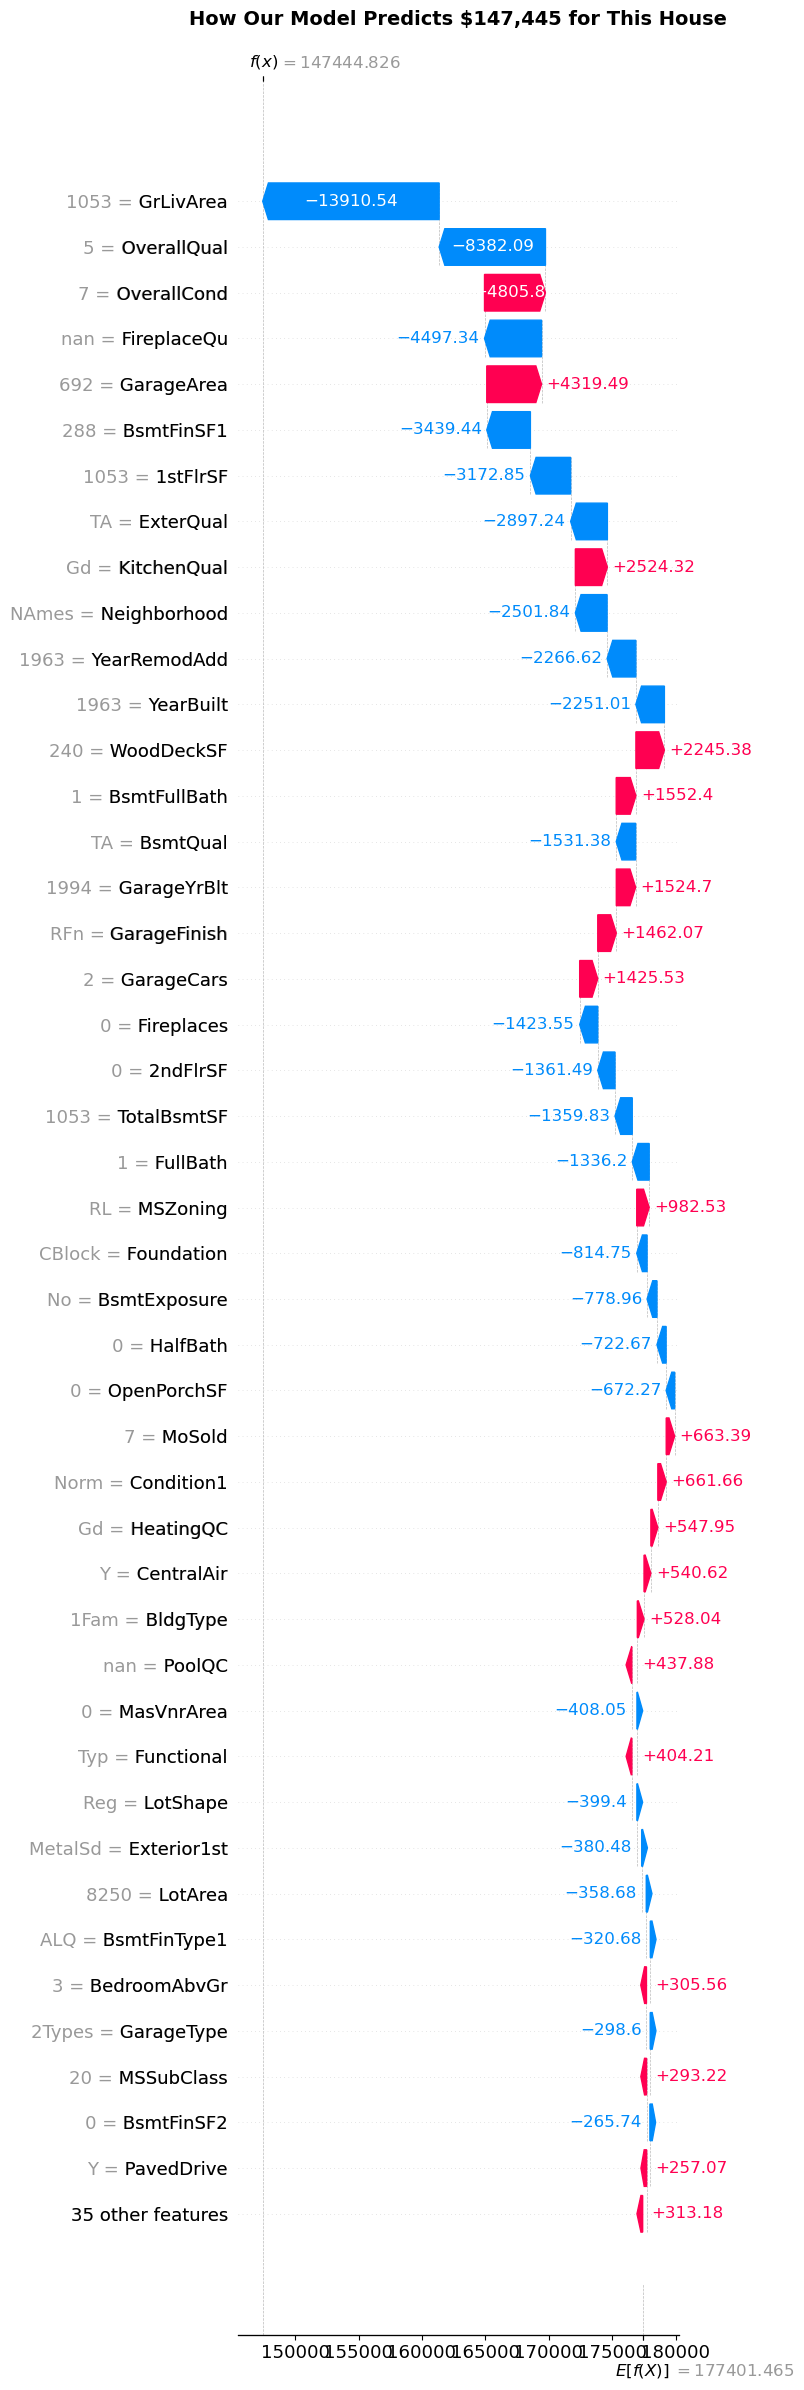

In [136]:
# Select an interesting prediction to explain
sample_idx = 0  # You can change this to explore different houses
sample_prediction = final_model.predict(X_test.iloc[[sample_idx]])[0]
actual_price = y_test.iloc[sample_idx]
 
print(f"Analyzing prediction for house index {sample_idx}:")
print(f"Predicted price: ${sample_prediction:,.2f}")
print(f"Actual price: ${actual_price:,.2f}")
print(f"Prediction error: ${abs(sample_prediction - actual_price):,.2f}")
 
# Create SHAP waterfall plot
plt.figure(figsize=(12, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx], 
        base_values=explainer.expected_value, 
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns.tolist()
    ),
    max_display=45,  # Show top contributing features
    show=False
)
plt.title(f'How Our Model Predicts ${sample_prediction:,.0f} for This House', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [138]:
# Analyze the feature contributions for our sample house
feature_values = X_test.iloc[sample_idx]
shap_contributions = shap_values[sample_idx]

# Create a detailed breakdown of contributions
feature_breakdown = pd.DataFrame({
    'Feature': X_test.columns,
    'Feature_Value': feature_values.values,
    'SHAP_Contribution': shap_contributions,
    'Impact': ['Increases Price' if x > 0 else 'Decreases Price' for x in shap_contributions]
}).sort_values('SHAP_Contribution', key=abs, ascending=False)

print("Top 10 Feature Contributions to This Prediction:")
print("=" * 60)
for idx, row in feature_breakdown.head(10).iterrows():
    impact_symbol = "↑" if row['SHAP_Contribution'] > 0 else "↓"
    if isinstance(row['Feature_Value'], (int, float)):
        value_str = f"{row['Feature_Value']:.1f}"
    else:
        value_str = str(row['Feature_Value'])

    print(f"{row['Feature']:20} {impact_symbol} ${row['SHAP_Contribution']:8,.0f} "
      f"(Value: {value_str})")

print(f"\nBase prediction: ${explainer.expected_value:,.2f}")
print(f"Sum of contributions: ${shap_contributions.sum():+,.2f}")
print(f"Final prediction: ${explainer.expected_value + shap_contributions.sum():,.2f}")

Top 10 Feature Contributions to This Prediction:
GrLivArea            ↓ $ -13,911 (Value: 1053)
OverallQual          ↓ $  -8,382 (Value: 5)
OverallCond          ↑ $   4,806 (Value: 7)
FireplaceQu          ↓ $  -4,497 (Value: nan)
GarageArea           ↑ $   4,319 (Value: 692.0)
BsmtFinSF1           ↓ $  -3,439 (Value: 288.0)
1stFlrSF             ↓ $  -3,173 (Value: 1053)
ExterQual            ↓ $  -2,897 (Value: TA)
KitchenQual          ↑ $   2,524 (Value: Gd)
Neighborhood         ↓ $  -2,502 (Value: NAmes)

Base prediction: $177,401.47
Sum of contributions: $-29,956.64
Final prediction: $147,444.83


### Global feature insights

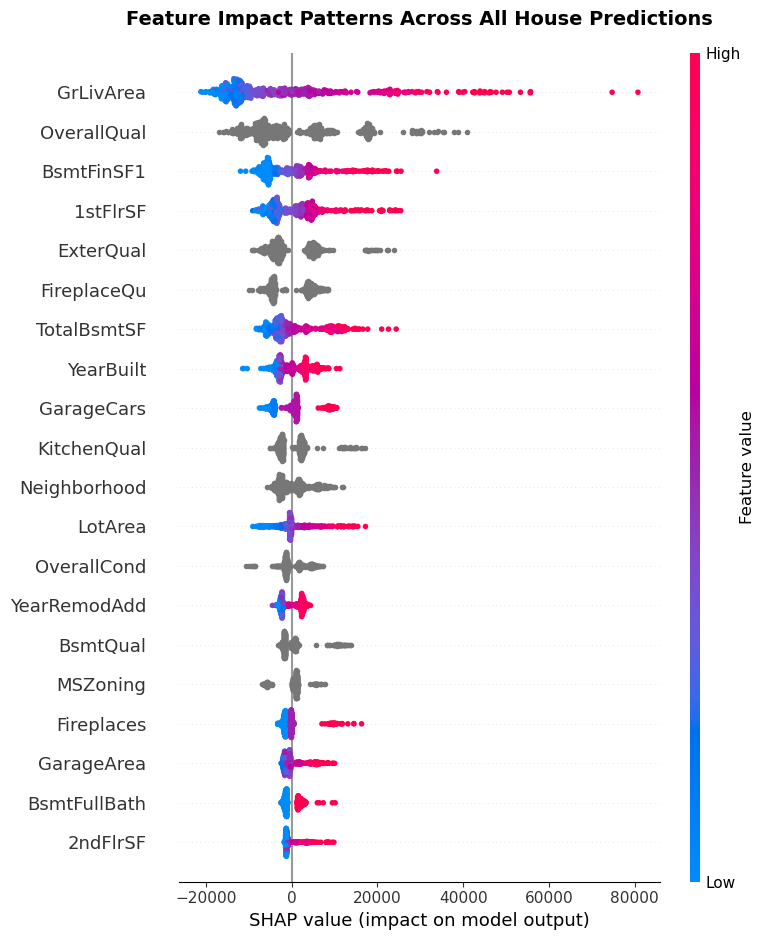

In [141]:
# Create SHAP summary plot to understand global feature patterns
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values, 
    X_test, 
    feature_names=X_test.columns.tolist(),
    max_display=20,  # Show top 20 most important features
    show=False
)
plt.title('Feature Impact Patterns Across All House Predictions', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Compare SHAP Values and feature_importances
**Note:** Because I am evaluating my SHAP values on a model trained on unseen data (X_test), I also need to consider feature_importances trained on this same data, not the full dataset (X, y) as was done above. This allows for a fair comparison between the two, but means the feature_importances here will differ from the feature importances in the above section, pulled from a model trained on the full dataset. *(i.e., cannot compare ranking in table below with feature_importances_df)*

In [143]:
# Compare SHAP importance with traditional feature importance
print("Feature Importance Comparison:")
print("-" * 50)

# SHAP-based importance (mean absolute SHAP values)
shap_importance = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

# Traditional CatBoost feature importance
cb_importance = final_model.get_feature_importance()

cb_ranking = pd.DataFrame({
    'Feature': X_test.columns,
    'CatBoost_Importance': cb_importance
}).sort_values('CatBoost_Importance', ascending=False)

print("Top 10 Most Important Features (SHAP vs CatBoost):")
print("SHAP Ranking\t\t\tCatBoost Ranking")
print("-" * 60)
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    cb_feat = cb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {cb_feat}")

print(f"\nKey Insights:")
print(f"Most impactful feature: {shap_ranking.iloc[0]['Feature']}")
print(f"Average SHAP impact per feature: ${np.mean(shap_importance):,.0f}")

Feature Importance Comparison:
--------------------------------------------------
Top 10 Most Important Features (SHAP vs CatBoost):
SHAP Ranking			CatBoost Ranking
------------------------------------------------------------
 1. GrLivArea      		 1. GrLivArea
 2. OverallQual    		 2. OverallQual
 3. BsmtFinSF1     		 3. ExterQual
 4. 1stFlrSF       		 4. 1stFlrSF
 5. ExterQual      		 5. BsmtFinSF1
 6. FireplaceQu    		 6. TotalBsmtSF
 7. TotalBsmtSF    		 7. GarageCars
 8. YearBuilt      		 8. YearBuilt
 9. GarageCars     		 9. FireplaceQu
10. KitchenQual    		10. BsmtQual

Key Insights:
Most impactful feature: GrLivArea
Average SHAP impact per feature: $1,331


In [147]:
# feature importances for model trained on all the data, X,y
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,feature,Importance
0,GrLivArea,20.049235
17,OverallQual,13.059694
27,ExterQual,10.451518
34,BsmtFinSF1,5.386018
38,TotalBsmtSF,5.361549
43,1stFlrSF,4.323913
60,GarageCars,3.935553
4,LotArea,3.028071
55,Fireplaces,2.463695
30,BsmtQual,1.930680


# Summary

[Contents](#Contents)

### Model scores and train-test gaps:

In [153]:
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap
Model _0_raw,0.9263,0.9834,0.9404,0.0430
Model _0,0.9260,0.9830,0.9363,0.0467
Model _1,0.9211,0.9736,0.9318,0.0418
Model _2,0.9200,0.9848,0.9261,0.0587


### Best model hyperparameters:
default params

### Top 10 feature importances:
on full dataset

In [156]:
feature_importances_df.sort_values(by=['Importance'], ascending=False)[:10]

,feature,Importance
0,GrLivArea,20.049235
17,OverallQual,13.059694
27,ExterQual,10.451518
34,BsmtFinSF1,5.386018
38,TotalBsmtSF,5.361549
43,1stFlrSF,4.323913
60,GarageCars,3.935553
4,LotArea,3.028071
55,Fireplaces,2.463695
30,BsmtQual,1.930680


### SHAP Analysis:
on train-test split data

In [158]:
print("Top 10 Most Important Features (SHAP vs CatBoost):")
print("SHAP Ranking\t\t\tCatBoost Ranking")
print("-" * 60)
for i in range(10):
    shap_feat = shap_ranking.iloc[i]['Feature'][:15]
    cb_feat = cb_ranking.iloc[i]['Feature'][:15]
    print(f"{i+1:2d}. {shap_feat:15s}\t\t{i+1:2d}. {cb_feat}")

Top 10 Most Important Features (SHAP vs CatBoost):
SHAP Ranking			CatBoost Ranking
------------------------------------------------------------
 1. GrLivArea      		 1. GrLivArea
 2. OverallQual    		 2. OverallQual
 3. BsmtFinSF1     		 3. ExterQual
 4. 1stFlrSF       		 4. 1stFlrSF
 5. ExterQual      		 5. BsmtFinSF1
 6. FireplaceQu    		 6. TotalBsmtSF
 7. TotalBsmtSF    		 7. GarageCars
 8. YearBuilt      		 8. YearBuilt
 9. GarageCars     		 9. FireplaceQu
10. KitchenQual    		10. BsmtQual


In [164]:
# save data for model comparisons
cb_models = tuning_results_df.copy()
cb_models['algorithm'] = 'CatBoost'

In [166]:
cb_models

,mean-cv on X and y,train score,test score,train-test gap,algorithm
Model _0,0.9260,0.9830,0.9363,0.0467,CatBoost
Model _0_raw,0.9263,0.9834,0.9404,0.0430,CatBoost
Model _1,0.9211,0.9736,0.9318,0.0418,CatBoost
Model _2,0.9200,0.9848,0.9261,0.0587,CatBoost


In [170]:
cb_models.index.name = 'model'
cb_models = cb_models.reset_index()

In [172]:
cb_models

,model,mean-cv on X and y,train score,test score,train-test gap,algorithm
0,Model _0,0.9260,0.9830,0.9363,0.0467,CatBoost
1,Model _0_raw,0.9263,0.9834,0.9404,0.0430,CatBoost
2,Model _1,0.9211,0.9736,0.9318,0.0418,CatBoost
3,Model _2,0.9200,0.9848,0.9261,0.0587,CatBoost


In [174]:
cb_models.to_csv('catboost_models.csv')

# Resources

[Contents](#Contents)

[CatBoost Essentials: Building Robust Home Price Prediction Systems](https://machinelearningmastery.com/catboost-essentials-building-robust-home-price-prediction-systems/)

# Extra

In [ ]:
# # define transformer for numerical features
# numerical_transformer = Pipeline(steps=[
#     ('num', 'passthrough')
# ])

# # define one-hot transformer for nominal features
# nominal_transformer = Pipeline(steps=[
#     ('nominal', OneHotEncoder(handle_unknown='ignore'))
# ])

# # define categories for ordinal encoding
# ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]

# # define ordinal transformer
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=ord_categories))
# ])

# # Set up preprocessor for all features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features_list),
#         ('nominal', nominal_transformer, nominal_features_list),
#         ('ordinal', ordinal_transformer, ordinal_features_list)
# ])

# # define model pipeline with preprocessor and regressor on default params
# pipelines = {
#    'gbm': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ensemble.GradientBoostingRegressor(random_state=42))])
# }

# train_results = {}
# for name, pipeline in pipelines.items():
#     pipeline.fit(X_train, y_train)
#     train_results[name] = name
#     train_score = pipeline.score(X_train, y_train)
#     test_score = pipeline.score(X_test, y_test)

#     print(f"{name} train score: {round(train_score, 4)}")
#     print(f"{name} test score: {round(test_score, 4)}")

### Double check encoding

In [ ]:
# X_train.head(5)

# for name, pipeline in pipelines.items():
#     pipeline.fit(X_train, y_train)
#     X_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
#     feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
#     transformed_df = pd.DataFrame(X_transformed, columns=feature_names, index=X_train.index)
#     print(name)
#     print(transformed_df.head())

# X_train.head(5)

# ordinal_order

In [ ]:
# def evaluate_max_depths(depth_range):
#     results = []
    
#     for max_depth_value in depth_range:
#         for name, pipeline in pipelines.items():
#             # Create a copy to avoid modifying the original
#             temp_pipeline = Pipeline(pipeline.steps)
#             temp_pipeline.named_steps['regressor'].set_params(
#                 max_depth=max_depth_value, 
#                 random_state=42
#             )
            
#             temp_pipeline.fit(X_train, y_train)
#             train_score = temp_pipeline.score(X_train, y_train)
#             test_score = temp_pipeline.score(X_test, y_test)
#             results.append({
#                 'model': name,
#                 'max_depth': max_depth_value,
#                 'training_score': train_score,
#                 'testing_score': test_score
#             })
    
#     return pd.DataFrame(results)

# max_depth_df = evaluate_max_depths(range(1, 20))
# max_depth_df

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# for i, model_name in enumerate(max_depth_df['model'].unique()):
#     model_data = max_depth_df[max_depth_df['model'] == model_name]
    
#     axes[i].plot(model_data['max_depth'], model_data['training_score'], 'o-', label='Training')
#     axes[i].plot(model_data['max_depth'], model_data['testing_score'], 's-', label='Testing')
#     axes[i].set_title(f'{model_name}: Training vs. Testing Scores')
#     axes[i].set_xticks(range(0, 21, 2))
#     axes[i].set_xlabel('Max. Depth')
#     axes[i].set_ylabel('R² Score')
#     axes[i].legend()
#     axes[i].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

### Look at feature importances

In [ ]:
# feature_importances = {}
# for name, pipeline in pipelines.items():
#     pipeline.fit(X_train, y_train)
#     importances = pipeline.named_steps['regressor'].feature_importances_
#     feature_importances[name] = importances     

# feature_importances

# # get feature names
# feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# # create dataframe
# feature_importances_df = pd.DataFrame(feature_importances, index=feature_names)
# feature_importances_df.sort_values(by=['forest'], ascending=False)

# # enforce same notation for both columns
# pd.set_option('display.float_format', '{:.6f}'.format)

# feature_importances_df.sort_values(by=['forest'], ascending=False).head(10)

# feature_importances_df.sort_values(by=['tree'], ascending=False).head(10)

# The top 5 features are the same for both models, but diverge after that.

# print('tree features 5-10:')
# print(feature_importances_df.sort_values(by=['tree'], ascending=False)[5:10])
# print(' ')
# print('forest features 5-10:')
# print(feature_importances_df.sort_values(by=['forest'], ascending=False)[5:10])

### Score the models using cross-validation, for model comparison 

In [162]:
# # define transformer for numerical features
# numerical_transformer = Pipeline(steps=[
#     ('num', 'passthrough')
# ])

# # define one-hot transformer for nominal features
# nominal_transformer = Pipeline(steps=[
#     ('nominal', OneHotEncoder(handle_unknown='ignore'))
# ])

# # define categories for ordinal encoding
# ord_categories = [ordinal_order[feature] for feature in ordinal_features_list]

# # define ordinal transformer
# ordinal_transformer = Pipeline(steps=[
#     ('ordinal', OrdinalEncoder(categories=ord_categories))
# ])

# # Set up preprocessor for all features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features_list),
#         ('nominal', nominal_transformer, nominal_features_list),
#         ('ordinal', ordinal_transformer, ordinal_features_list)
# ])

# # define model pipeline with preprocessor and regressor on default params
# pipelines = {
#     'gbm': Pipeline(steps=[('preprocessor', preprocessor), ('regressor', ensemble.GradientBoostingRegressor(random_state=42))])
# }

# cv_results = {}
# for name, pipeline in pipelines.items():
#     pipeline.fit(X, y)
#     scores = cross_val_score(pipeline, X, y)
#     test_score = pipeline.score(X_test, y_test)
    
#     print(f"{name} cv score: {round(scores.mean(), 4)}")

In [ ]:
# # evaluate model with best params

# # Initialize model
# model_cv = CatBoostRegressor(
#     cat_features=cat_features,
#     random_seed=42,
#     verbose=0,
#     depth = 6,
#     iterations = 200, 
#     l2_leaf_reg = 1, 
#     learning_rate = 0.1
# )

# model_cv.fit(X, y)

# # return scores
# scores = cross_val_score(model_cv, X, y, cv=5, scoring='r2') 
# print(f"mean cv score: {round(scores.mean(), 4):.4f}")